In [2]:
# import modules
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# set display
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
figsiz = [14,8]
%matplotlib inline

C:\Users\mom1\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# read data
path = 'C:/Users/mom1/Desktop/ds/'
voters = pd.read_csv(path + 'voters.csv')
print(voters.shape)
print(voters.columns)
voters.head()

(434624, 18)
Index([u'prim_id', u'la1', u'la3', u'voted_03_05_2013', u'voted_05_21_2013',
       u'voted_06_07_2016', u'demplus', u'age', u'repplus', u'party',
       u'abrscore', u'hpt_nt', u'ismarried', u'home', u'renters', u'ethnic',
       u'sex', u'hhcount'],
      dtype='object')


,prim_id,la1,la3,voted_03_05_2013,voted_05_21_2013,voted_06_07_2016,demplus,age,repplus,party,abrscore,hpt_nt,ismarried,home,renters,ethnic,sex,hhcount
0,19101063480,0,1,1,0,1,N,42.0,Y,R,ML,S,Y,H,N,X,M,3
1,19101122779,0,0,0,0,1,Y,53.0,N,D,NaN,A,N,NaN,N,X,M,1
2,19101930697,1,1,1,1,1,Y,70.0,N,D,ML,B,N,H,N,X,M,2
3,19102226061,0,0,0,0,0,N,57.0,Y,R,NaN,C,N,NaN,Y,NaN,F,2
4,19104235280,0,0,0,0,0,N,51.0,N,DS,OL,1,Y,H,N,X,M,2


As mentioned voters.csv contains information of almost 400k registered voters.

We have 18 features.
Let us first rename some to ease readability

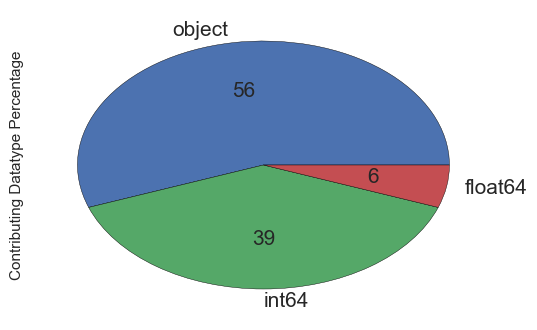

In [13]:
voters.rename(columns={"la1":"VFreq","la3":"Freq"},inplace=True)
# let's see what datatypes are we dealing with
#pd.DataFrame(voters.dtypes.value_counts()).plot(kind='bar', 
 #                                               title="Datatype Count",legend=False,figsize=figsiz)
    
pd.Series(voters.dtypes.value_counts(),name="Contributing Datatype Percentage").plot.pie(autopct='%.0f',fontsize=15) #autopct='%.2f

Most of them are of 'object' type which is fairly normal and easy to work with #grand total=101,why?

### Missing value percentage

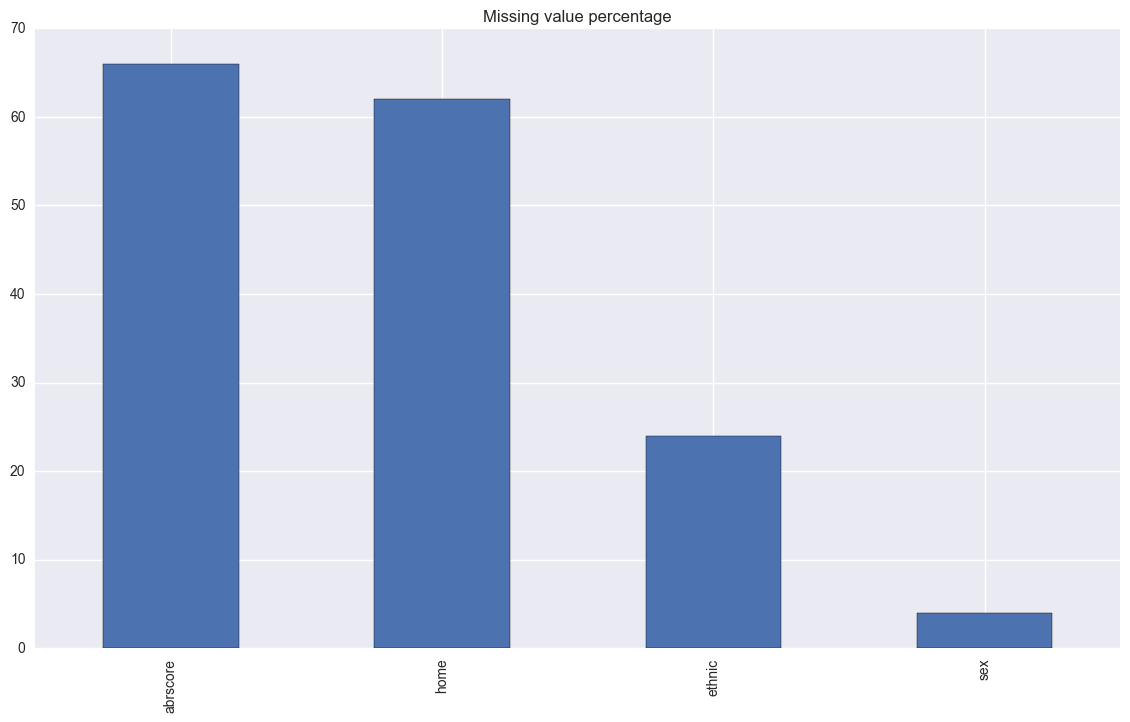

In [7]:
(voters.apply(lambda x : sum(x.isnull().values)*100/len(voters))).\
    replace(0,np.nan).dropna().sort_values(ascending=False).\
        plot(kind='bar',title='Missing value percentage',figsize=figsiz);
#for each column calculate the missing percent
    #remove cols with no missing data and sort
        #plot

More than 50% is missing for home and abrscore
<br>
Missing values in home can be filled in contrast with renters columns

## Correlation

In [17]:
c = voters.corr()
c

,prim_id,VFreq,Freq,voted_03_05_2013,voted_05_21_2013,voted_06_07_2016,age,hhcount
prim_id,1.000000,-0.087978,-0.115105,-0.102873,-0.098618,-0.068287,-0.179532,-0.011526
VFreq,-0.087978,1.000000,0.768464,0.737397,0.703025,0.428534,0.352352,0.000680
Freq,-0.115105,0.768464,1.000000,0.712265,0.725105,0.490619,0.403893,0.017402
voted_03_05_2013,-0.102873,0.737397,0.712265,1.000000,0.664752,0.357304,0.400669,0.011050
voted_05_21_2013,-0.098618,0.703025,0.725105,0.664752,1.000000,0.361528,0.389657,0.019682
voted_06_07_2016,-0.068287,0.428534,0.490619,0.357304,0.361528,1.000000,0.205459,0.015773
age,-0.179532,0.352352,0.403893,0.400669,0.389657,0.205459,1.000000,-0.032443
hhcount,-0.011526,0.000680,0.017402,0.011050,0.019682,0.015773,-0.032443,1.000000


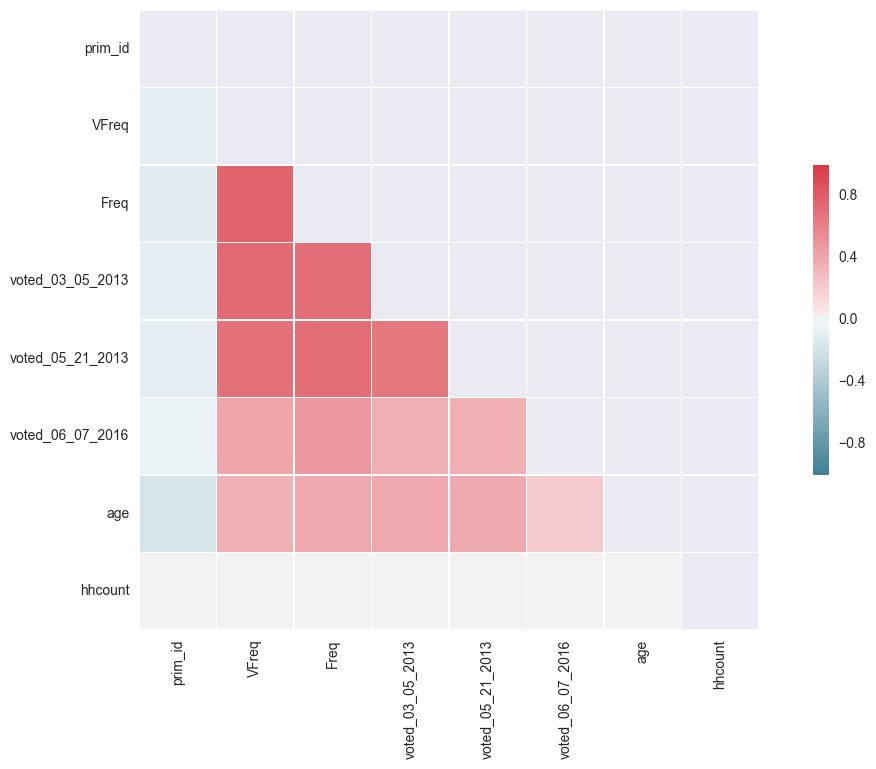

In [20]:
mask = np.zeros_like(c, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=figsiz)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(c, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

VFreq is corelated to Freq,voted_03_05_2013 and voted_05_21_2013 at >70%
<br>
Similar result can be seen for Freq

## Quantitative columns

In [8]:
quantitive_columns = voters.select_dtypes(include=[np.number]).columns
qualitative_columns = voters.select_dtypes(include=[object]).columns
assert len(qualitative_columns) + len(quantitive_columns) == voters.shape[1]

In [9]:
voters.describe()

C:\Users\mom1\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,prim_id,VFreq,Freq,voted_03_05_2013,voted_05_21_2013,voted_06_07_2016,age,hhcount
count,4.346240e+05,434624.000000,434624.000000,434624.000000,434624.000000,434624.000000,434540.000000,434624.000000
mean,1.841541e+10,0.175591,0.264992,0.183034,0.187615,0.418511,47.436804,2.117359
std,4.159902e+09,0.380472,0.441330,0.386695,0.390405,0.493315,18.532434,1.125396
min,1.910060e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.934678e+10,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000
50%,1.952426e+10,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000
75%,1.952653e+10,0.000000,1.000000,0.000000,0.000000,1.000000,NaN,3.000000
max,1.952793e+10,1.000000,1.000000,1.000000,1.000000,1.000000,99.000000,11.000000


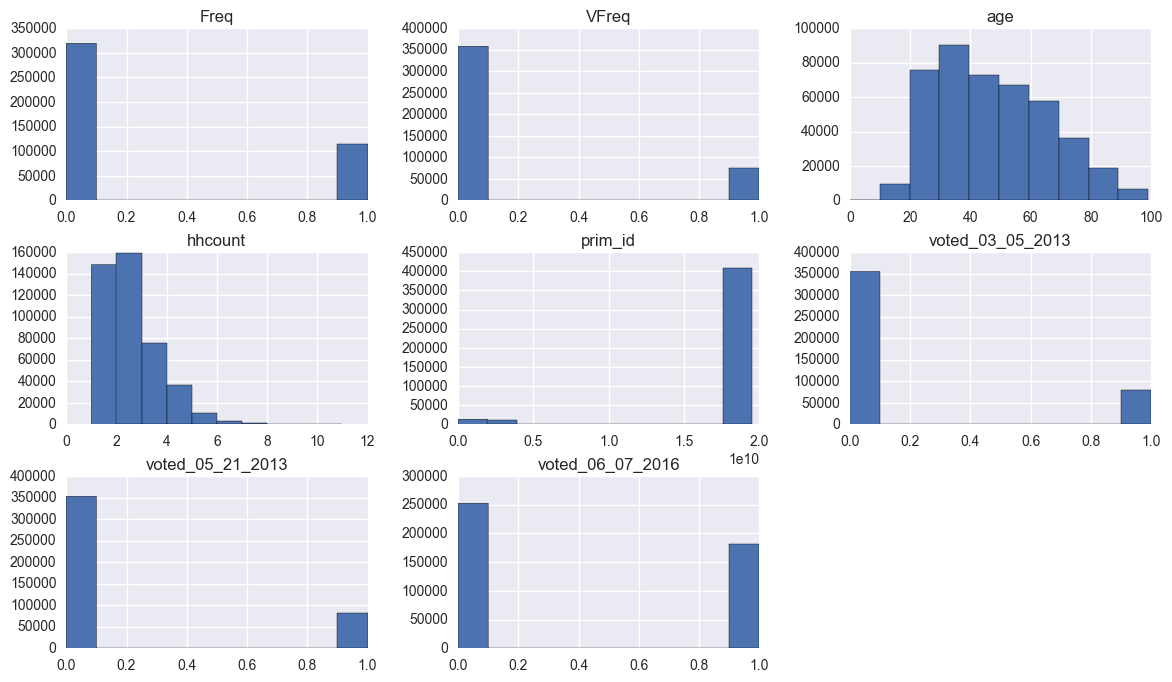

In [10]:
voters[quantitive_columns].hist(figsize=figsiz);

As seen above, age has some null values, except those they start after the voting age. Most voters are 20-40
<br>
As expected Freq is higher than VFreq
<br>
Also, the number of voters increased in 2016
<br>
hhcount is pretty resonable, with majority between 2-4
<br>
Let's check exactly how many unique values it has

In [18]:
sorted(voters.hhcount.unique()) # we can change it to categorical variable 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

## Qualitative columns

In [367]:
voters[qualitative_columns].describe()

Index(['demplus', 'repplus', 'party', 'abrscore', 'hpt_nt', 'ismarried',
       'home', 'renters', 'ethnic', 'sex'],
      dtype='object')

Frequency distributions

In [1]:
for c in qualitative_columns:
    ax = pd.DataFrame(voters[c].value_counts()/len(voters)*100).plot(kind='bar',figsize=figsiz);
    for p in ax.patches: # add value to each bar
        ax.annotate('{:.2f}%'.format(p.get_height()),(p.get_x()+0.15, p.get_height()+.15),color='red',fontsize=15) 
    plt.show()

NameError: name 'qcs' is not defined

We have more of dem party supporters in our data.First three plots are in sync showing the same <br>
Also hpt_nt suggesting highest of B with  2+ pure dem supporters <br>
<br>
<br>
Majority of the voters are not married yet<br>
abrscore is reasonably high on once late followed by always late<br>
home is filled with just one value, and as seen earlier has a lot of missing values, so I think if not the owners they're marked as renters and home is left null<br>
renters and gender is faily distributed
ethnicity is high on generic followed by Hispanics and Jews <br>

Predictions

Importing support.csv

In [23]:
support = pd.read_csv(path + 'support.csv')
print(support.shape)
print(support.columns)
support.head()

(1577, 2)
Index([u'prim_id', u'support'], dtype='object')


,prim_id,support
0,19523066036,candidate_b
1,19523244550,candidate_b
2,19491481087,candidate_a
3,19526211987,candidate_a
4,19214836641,candidate_a


Merge with voter info

In [45]:
data=pd.merge(voters,support,left_index=True,right_index=True)
del data["prim_id_y"]
data=data.rename(columns={"prim_id_x":"prim_id"})
print data.shape
data.head()

(1577, 19)


,prim_id,VFreq,Freq,voted_03_05_2013,voted_05_21_2013,voted_06_07_2016,demplus,age,repplus,party,abrscore,hpt_nt,ismarried,home,renters,ethnic,sex,hhcount,support
0,19101063480,0,1,1,0,1,N,42.0,Y,R,ML,S,Y,H,N,X,M,3,candidate_b
1,19101122779,0,0,0,0,1,Y,53.0,N,D,NaN,A,N,NaN,N,X,M,1,candidate_b
2,19101930697,1,1,1,1,1,Y,70.0,N,D,ML,B,N,H,N,X,M,2,candidate_a
3,19102226061,0,0,0,0,0,N,57.0,Y,R,NaN,C,N,NaN,Y,NaN,F,2,candidate_a
4,19104235280,0,0,0,0,0,N,51.0,N,DS,OL,1,Y,H,N,X,M,2,candidate_a


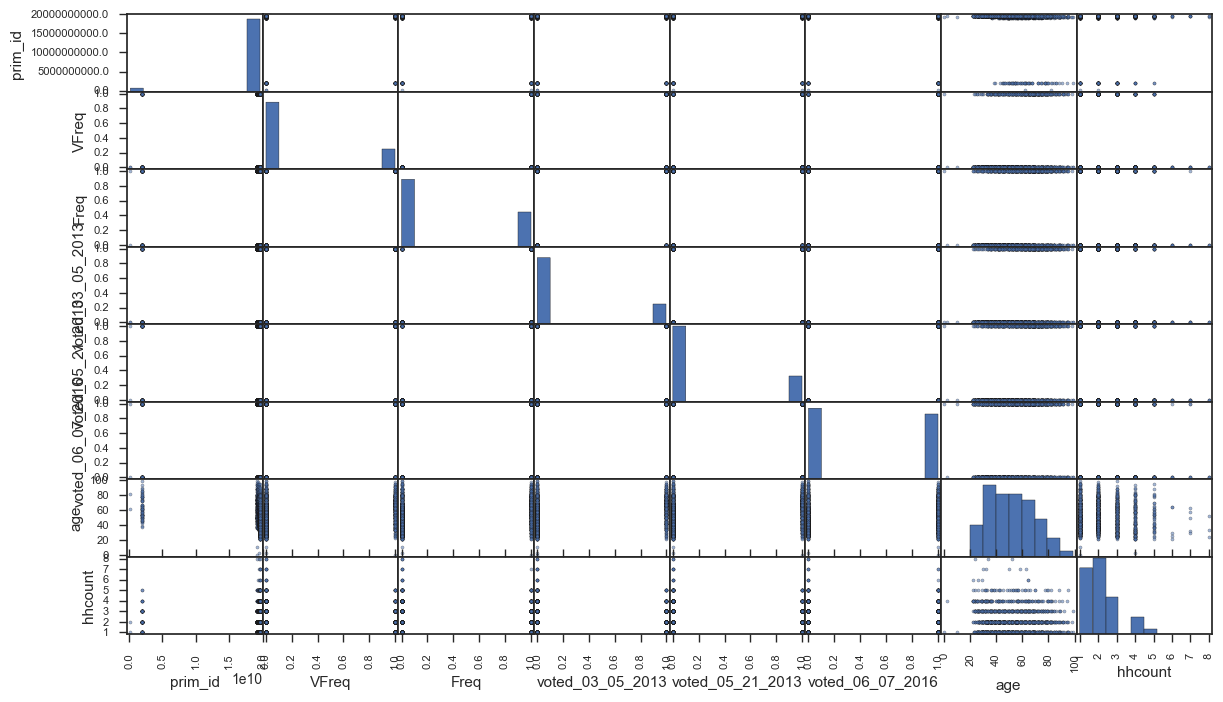

In [46]:
scatter_matrix(data,figsize=figsiz)
plt.show()

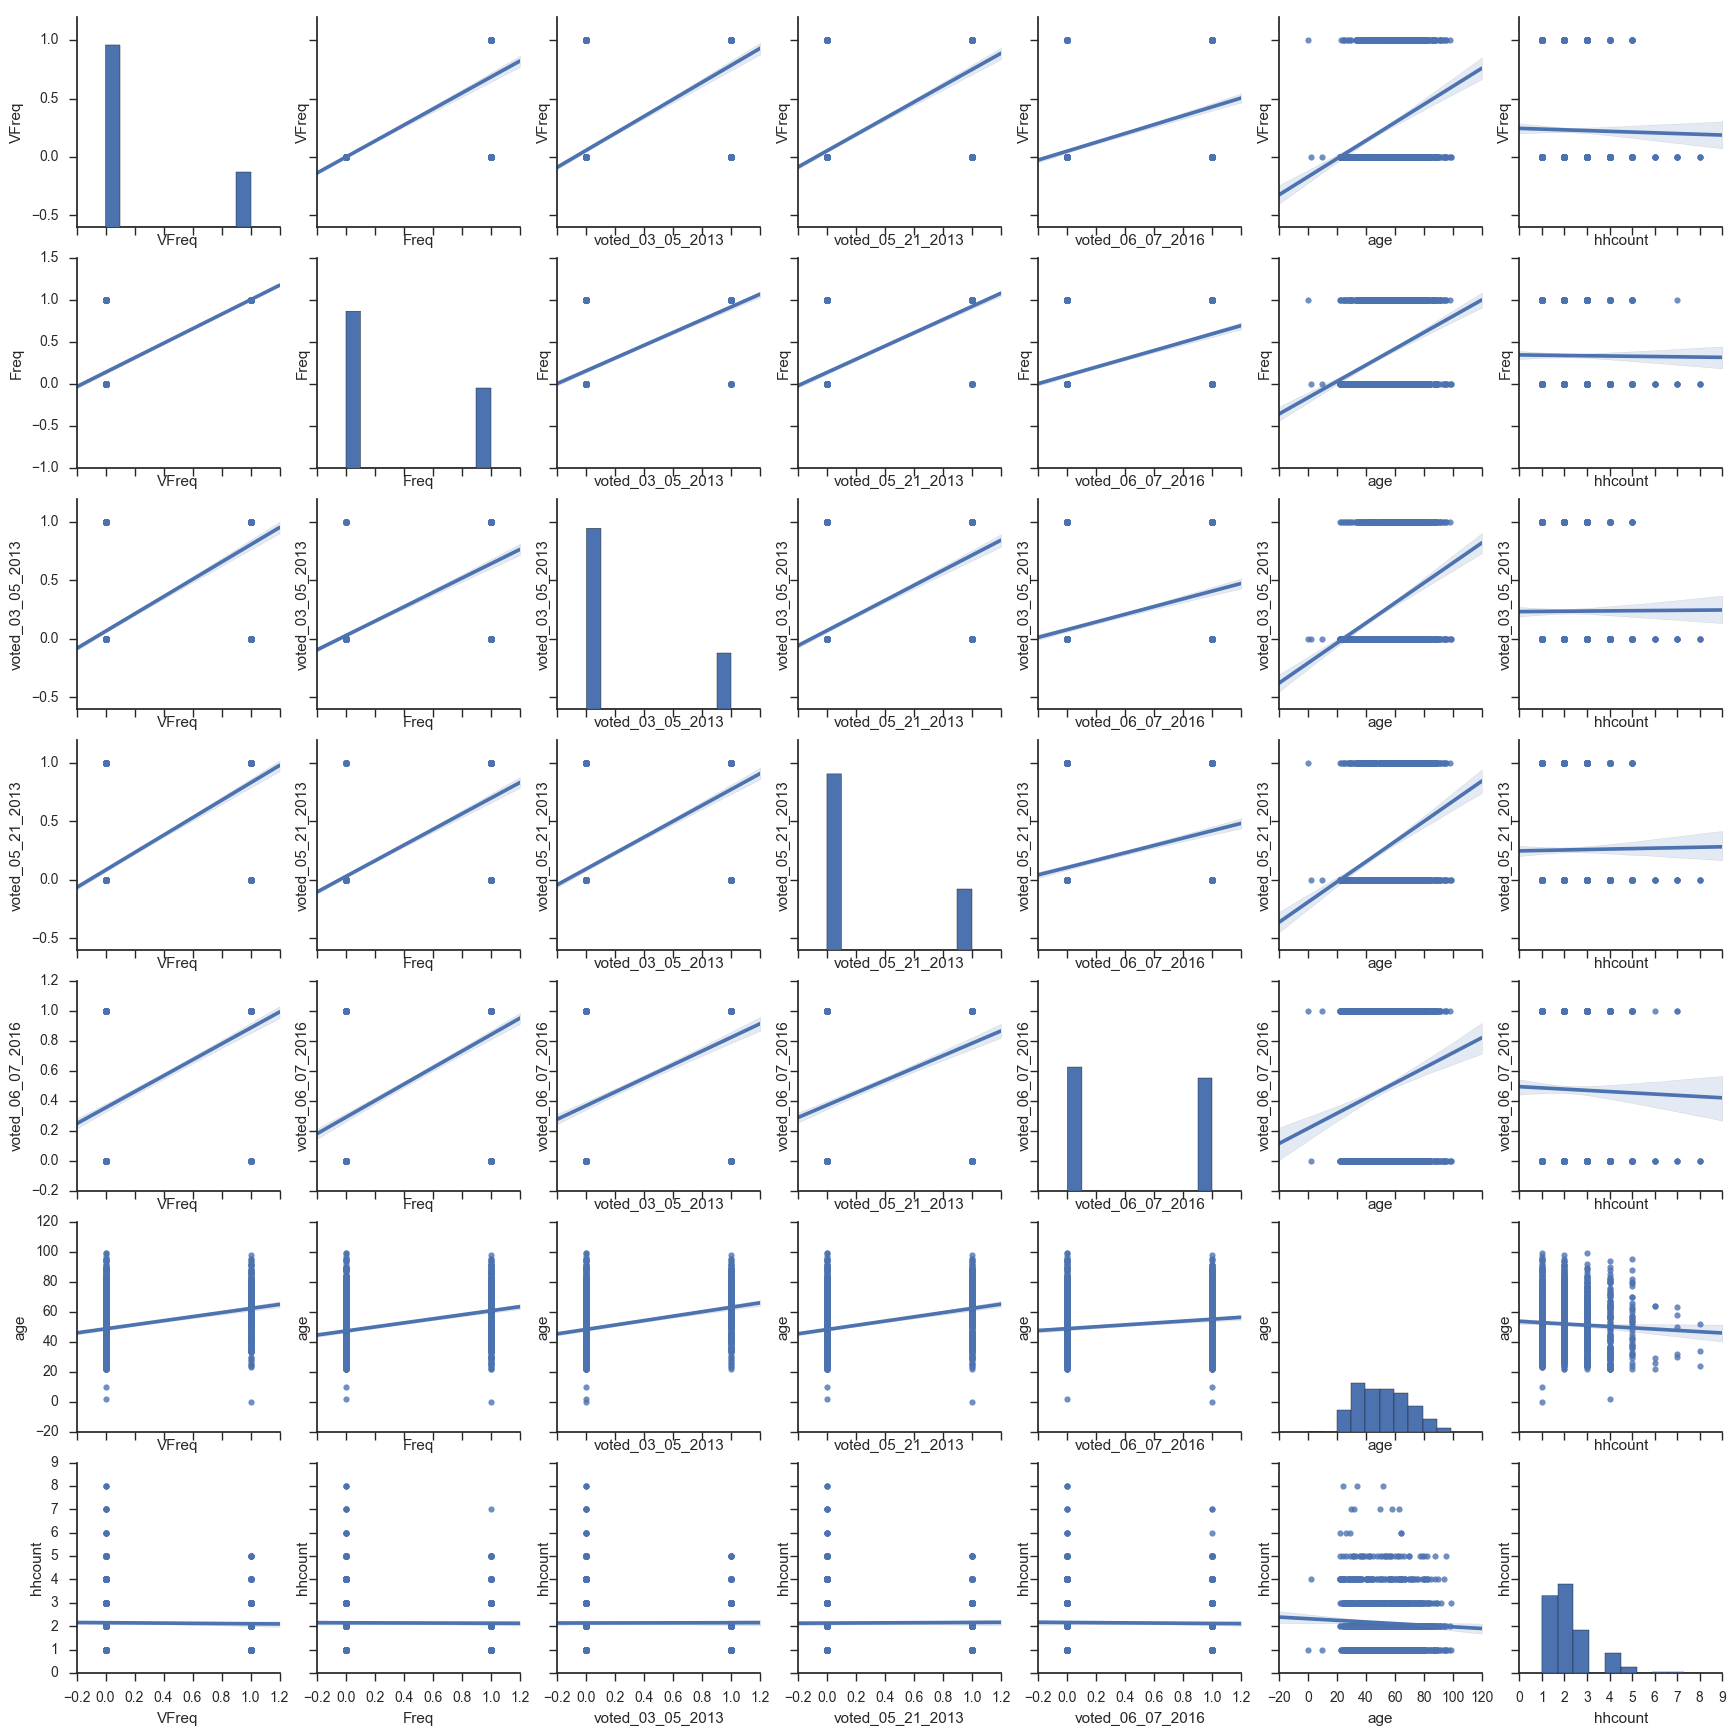

In [52]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data[quantitive_columns[1:]],kind="reg")

xlabels,ylabels = [],[]
for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)
for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].xaxis.set_label_text(xlabels[i])
        g.axes[j,i].yaxis.set_label_text(ylabels[j])

sns.plt.show()

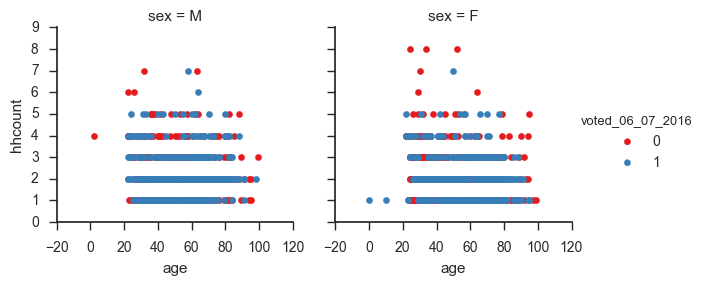

In [48]:
g = sns.FacetGrid(data, col="sex", hue="voted_06_07_2016", palette="Set1")
g = (g.map(plt.scatter, "age",'hhcount').add_legend())
sns.plt.show()

In [49]:
data.columns

Index([u'prim_id', u'VFreq', u'Freq', u'voted_03_05_2013', u'voted_05_21_2013',
       u'voted_06_07_2016', u'demplus', u'age', u'repplus', u'party',
       u'abrscore', u'hpt_nt', u'ismarried', u'home', u'renters', u'ethnic',
       u'sex', u'hhcount', u'support'],
      dtype='object')

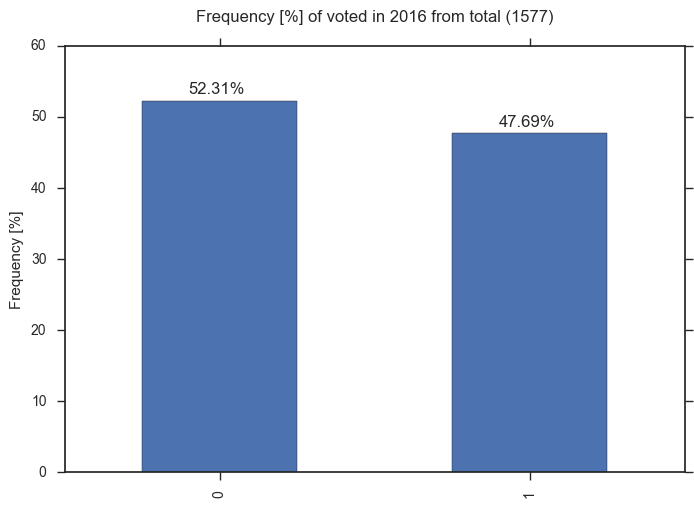

In [54]:
ax = (data.voted_06_07_2016.value_counts()/len(data)*100).plot(kind="bar")
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.title('Frequency [%] of voted in 2016 from total (1577)\n')
plt.ylabel('Frequency [%]')
plt.show()

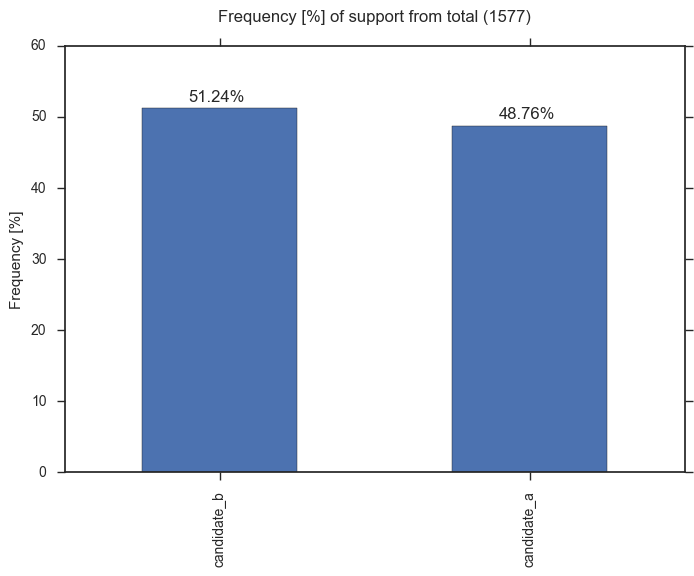

In [56]:
ax = (data.support.value_counts()/len(data)*100).plot(kind="bar")
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.title('Frequency [%] of support from total (1577)\n')
plt.ylabel('Frequency [%]')
plt.show()

In [74]:
age_group = np.array([data.age.quantile(1.0/6*i) for i in range(1,5)])
data['Age_group_numeric']=data.age.apply(lambda x: sum(age_group<x)+1)
age_group_dict = {1: '(0, 33]', 2: '(34, 41]', 3: '(42, 50]', 4: '(51, 60]', 5: '(61, 99]'}
data['Age_group'] = data.Age_group_numeric.apply(lambda x: age_group_dict.get(x))
data.groupby('Age_group').apply(lambda x: x.shape[0])

Age_group
(0, 33]     281
(34, 41]    253
(42, 50]    259
(51, 60]    268
(61, 99]    516
dtype: int64

In [142]:
predictors = [u'Freq', u'voted_03_05_2013', u'voted_05_21_2013',
       u'voted_06_07_2016', u'demplus', u'age', u'ismarried', u'renters',
       u'sex', u'hhcount']

In [87]:
for i in predictors:
    data[i]=data[i].astype('category',copy=False)

In [132]:
cols= [ u'demplus', u'ismarried','renters']
for c in cols:
    data[c] = data[c].map(lambda x: 1 if x=='Y' else 0)

In [140]:
print(sum(data.sex.isnull()))
data.sex.value_counts()

39


F    802
M    736
Name: sex, dtype: int64

In [141]:
data.sex = data.sex.map(lambda x: 1 if x=='F' else 0) # 39 nulls to M since F=802,M=736

In [149]:
data.sex.fillna(0,inplace=True)

In [151]:
print(sum(data.sex.isnull()))
data.sex.value_counts()

0


1    802
0    775
Name: sex, dtype: int64

In [143]:
pre=['Freq', 'voted_03_05_2013', 'voted_05_21_2013',
       u'voted_06_07_2016', u'ismarried']

In [159]:
from sklearn.dummy import DummyClassifier
X=data[predictors]
y=data['support']
X=preprocessing.minmax_scale(X)
X_train, X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)

#train a dummy classifier to make predictions based on the class values
new_dummy_classifier = DummyClassifier(strategy="stratified")
new_dummy_classifier.fit( X_train,y_train )

y_pred = new_dummy_classifier.predict(X_test)
print "\nTest set accuracy is ", accuracy_score(y_test,y_pred)*100,"\n"
print(pd.crosstab(y_test, y_pred)), "\n"
print "Classification Report:\n", (metrics.classification_report(y_test,y_pred))
print("\nNumber of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))


Test set accuracy is  54.1139240506 

col_0        candidate_a  candidate_b
support                              
candidate_a           81           73
candidate_b           72           90 

Classification Report:
             precision    recall  f1-score   support

candidate_a       0.53      0.53      0.53       154
candidate_b       0.55      0.56      0.55       162

avg / total       0.54      0.54      0.54       316


Number of mislabeled points out of a total 316 points : 145


In [158]:
X=data[predictors]
y=data['support']
X=preprocessing.minmax_scale(X)
X_train, X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)
for K in [3,5,10,15]:
    neigh = KNeighborsClassifier(n_neighbors = K)
    neigh.fit(X_train, y_train) 
    y_pred = neigh.predict(X_test)
    print "\nTest set accuracy is ", accuracy_score(y_test,y_pred)*100,"% for K-Value:",K ,"\n"
    print(pd.crosstab(y_test, y_pred)), "\n"
    print "Classification Report:\n", (metrics.classification_report(y_test,y_pred))
    print("\nNumber of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))
    print "--------------------------"


Test set accuracy is  45.5696202532 % for K-Value: 3 

col_0        candidate_a  candidate_b
support                              
candidate_a           62           92
candidate_b           80           82 

Classification Report:
             precision    recall  f1-score   support

candidate_a       0.44      0.40      0.42       154
candidate_b       0.47      0.51      0.49       162

avg / total       0.45      0.46      0.45       316


Number of mislabeled points out of a total 316 points : 172
--------------------------

Test set accuracy is  50.6329113924 % for K-Value: 5 

col_0        candidate_a  candidate_b
support                              
candidate_a           71           83
candidate_b           73           89 

Classification Report:
             precision    recall  f1-score   support

candidate_a       0.49      0.46      0.48       154
candidate_b       0.52      0.55      0.53       162

avg / total       0.51      0.51      0.51       316


Number of misla

In [160]:
model = GaussianNB()
X=data[predictors]
y=data['support']
X=preprocessing.minmax_scale(X)
X_train, X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)
model.fit(X_train, y_train)
print(model)
# make predictions
y_pred = model.predict(X_test)
# summarize the fit of the model
print "\nTest set accuracy is ", accuracy_score(y_test,y_pred)*100,"\n"
print(pd.crosstab(y_test, y_pred)), "\n"
print "Classification Report:\n", (metrics.classification_report(y_test, y_pred))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

GaussianNB(priors=None)

Test set accuracy is  49.6835443038 

col_0        candidate_a  candidate_b
support                              
candidate_a           53          101
candidate_b           58          104 

Classification Report:
             precision    recall  f1-score   support

candidate_a       0.48      0.34      0.40       154
candidate_b       0.51      0.64      0.57       162

avg / total       0.49      0.50      0.49       316

Number of mislabeled points out of a total 316 points : 159


In [161]:
model = BernoulliNB()
X=data[predictors]
y=data['support']
X=preprocessing.minmax_scale(X)
X_train, X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)
model.fit(X_train, y_train)
print(model)
# make predictions
y_pred = model.predict(X_test)
# summarize the fit of the model
print "\nTest set accuracy is ", accuracy_score(y_test,y_pred)*100,"\n"
print(pd.crosstab(y_test, y_pred)), "\n"
print "Classification Report:\n", (metrics.classification_report(y_test, y_pred))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Test set accuracy is  50.9493670886 

col_0        candidate_a  candidate_b
support                              
candidate_a           55           99
candidate_b           56          106 

Classification Report:
             precision    recall  f1-score   support

candidate_a       0.50      0.36      0.42       154
candidate_b       0.52      0.65      0.58       162

avg / total       0.51      0.51      0.50       316

Number of mislabeled points out of a total 316 points : 155


In [163]:
model = MultinomialNB()
X=data[predictors]
y=data['support']
X=preprocessing.minmax_scale(X)
X_train, X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
print "\nTest set accuracy is ", accuracy_score(y_test,y_pred)*100,"\n"
print(pd.crosstab(y_test, y_pred)), "\n"
print "Classification Report:\n", (metrics.classification_report(y_test, y_pred))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Test set accuracy is  50.3164556962 

col_0        candidate_a  candidate_b
support                              
candidate_a           45          109
candidate_b           48          114 

Classification Report:
             precision    recall  f1-score   support

candidate_a       0.48      0.29      0.36       154
candidate_b       0.51      0.70      0.59       162

avg / total       0.50      0.50      0.48       316

Number of mislabeled points out of a total 316 points : 157


In [164]:
model = SVC()
X=data[predictors]
y=data['support']
X=preprocessing.minmax_scale(X)
X_train, X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
print "\nTest set accuracy is ", accuracy_score(y_test,y_pred)*100,"\n"
print(pd.crosstab(y_test, y_pred)), "\n"
print "Classification Report:\n", (metrics.classification_report(y_test,y_pred))
print("\nNumber of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Test set accuracy is  49.3670886076 

col_0        candidate_a  candidate_b
support                              
candidate_a           35          119
candidate_b           41          121 

Classification Report:
             precision    recall  f1-score   support

candidate_a       0.46      0.23      0.30       154
candidate_b       0.50      0.75      0.60       162

avg / total       0.48      0.49      0.46       316


Number of mislabeled points out of a total 316 points : 160


In [172]:
X=data[predictors]
sorted(zip(X.columns.values,clf.feature_importances_), key = lambda x: x[1], reverse = True)

[('age', 0.39971374754280314),
 ('hhcount', 0.16647998968052172),
 ('demplus', 0.09262198385666609),
 ('voted_06_07_2016', 0.086798794858596082),
 ('renters', 0.07171772594753828),
 ('ismarried', 0.062673815878164382),
 ('sex', 0.04196481304744494),
 ('Freq', 0.0412080365450819),
 ('voted_03_05_2013', 0.031523844624116532),
 ('voted_05_21_2013', 0.0052972480190669)]

In [179]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
y=data['support']
X=preprocessing.minmax_scale(X)
X_train, X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
preds = clf.predict(X = X_test)
print (clf.tree_.node_count, get_max_node_depths(clf.tree_))

(1201L, 24)


In [180]:
print(pd.crosstab(y_test, preds))
print(metrics.classification_report(y_true = y_test, y_pred = preds))

col_0        candidate_a  candidate_b
support                              
candidate_a           72           82
candidate_b           87           75
             precision    recall  f1-score   support

candidate_a       0.45      0.47      0.46       154
candidate_b       0.48      0.46      0.47       162

avg / total       0.47      0.47      0.47       316

